In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV


sns.set()
%matplotlib inline

In [2]:
## Automate the splitting, training and validation

def split_train_val(data):
    validate = data[data.Year > 2016]
    train = data[data.Year <= 2016]

    train.drop('DATE', axis=1, inplace=True)
    validate.drop('DATE', axis=1, inplace=True)
    
    y_train = train['mission']
    X_train = train.drop('mission', axis=1)

    y_validate = validate['mission']
    X_validate = validate.drop('mission', axis=1)
    
    return X_train, y_train, X_validate, y_validate
    
def test_model(m, X_validate, y_validate):
    print('Validate Score: ',m.score(X_validate, y_validate))
    y_score = [x[1] for x in m.predict_proba(X_validate)]
    fpr, tpr, thresholds = roc_curve(y_validate, y_score)
    print('ROC AUC: ', roc_auc_score(y_validate,y_score)) # my model

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return True

In [3]:
data = pd.read_csv('../data/interim/sar_final.csv')

In [4]:
data['holiday'] = data['holiday'].astype(bool)
data['Is_month_end'] = data['Is_month_end'].astype(bool)
data['Is_quarter_end'] = data['Is_quarter_end'].astype(bool)
data['Is_year_end'] = data['Is_year_end'].astype(bool)
data['Is_year_start'] = data['Is_year_start'].astype(bool)


In [5]:
X_train, y_train, X_validate, y_validate = split_train_val(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6289 entries, 0 to 6288
Data columns (total 32 columns):
mission            6281 non-null float64
Year               6281 non-null float64
Month              6281 non-null float64
Week               6281 non-null float64
Day                6281 non-null float64
Dayofweek          6281 non-null float64
Dayofyear          6281 non-null float64
Is_month_end       6289 non-null bool
Is_quarter_end     6289 non-null bool
Is_year_end        6289 non-null bool
Is_year_start      6289 non-null bool
Elapsed            6281 non-null float64
DATE               6281 non-null object
AWND_x             6281 non-null float64
PRCP_x             6281 non-null float64
TAVG_x             6281 non-null float64
TMAX_x             6281 non-null float64
TMIN_x             6281 non-null float64
WT01               6281 non-null float64
WT03               6281 non-null float64
WT10               6281 non-null float64
AWND_y             6281 non-null float64
PRCP

/home/afederation/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


/home/afederation/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Score:  0.7169016663614722
Validate Score:  0.6634146341463415
ROC AUC:  0.480571984228474


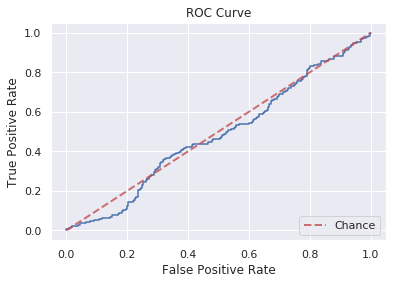

True

In [6]:
# Logistic Regresstion
m = LogisticRegression()
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)

Training Score:  0.7169016663614722
Validate Score:  0.6634146341463415
ROC AUC:  0.519428015771526


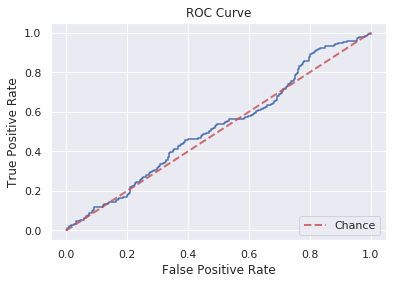

True

In [7]:
# Naive Bayes
m = GaussianNB()
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)

Training Score:  1.0
Validate Score:  0.6585365853658537
ROC AUC:  0.6056285965473145


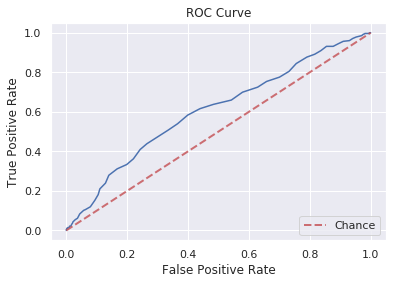

True

In [8]:
# Random Forest
m = RandomForestClassifier(n_estimators=100)
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)

Training Score:  0.7355795641823841
Validate Score:  0.5878048780487805
ROC AUC:  0.612412084398977


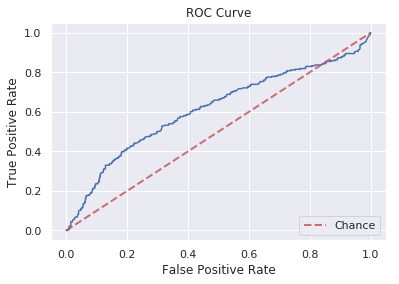

True

In [9]:
# AdaBoost
m = AdaBoostClassifier(n_estimators=100)
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)


Training Score:  0.7509613623878411
Validate Score:  0.6878048780487804
ROC AUC:  0.6381007566069906


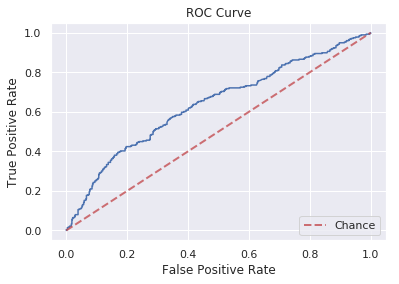

True

In [10]:
from xgboost import XGBClassifier
m = XGBClassifier()
m.fit(X_train, y_train)
print('Training Score: ', m.score(X_train, y_train))
test_model(m, X_validate, y_validate)
    

XGBoost does best out of the box. Let's tune it. [Reference 1](https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde) [Reference 2](https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost)

There isn't a lot of data, so we can perform an exhaustive grid search.


In [11]:
xgb = XGBClassifier(scale_pos_weight=2.3)
hp_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
             "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
             "min_child_weight" : [ 1, 3, 5, 7 ],
             "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

clf = GridSearchCV(xgb, hp_grid, n_jobs=5,
                   scoring='roc_auc',
                   verbose=2, refit=True)
clf.fit(X_train, y_train)


Fitting 3 folds for each of 3840 candidates, totalling 11520 fits


/home/afederation/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    8.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   44.7s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:  4.9min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  7.0min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed:  9.4min
[Parallel(n_jobs=5)]: Done 2582 tasks      | elapsed: 12.2min
[Parallel(n_jobs=5)]: Done 3271 tasks      | elapsed: 15.7min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 19.8min
[Parallel(n_jobs=5)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2.3, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'min_child_weight': [1, 3, 5, 7], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.3, 0.4, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

Does it give the same type of errors as the RF

In [12]:
# combine into voting classifier

from sklearn.ensemble import VotingClassifier

m1 = XGBClassifier(booster='gbtree', silent=True, learning_rate=0.1, max_depth=1)
m2 = AdaBoostClassifier()
m3 = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)

mv = VotingClassifier(estimators=[('xgb', m1), ('ada', m2), ('rf', m3)], voting='hard')
mv.fit(X_train, y_train)
print('Validate Score: ',mv.score(X_validate, y_validate))


Validate Score:  0.6707317073170732
